# Сегментация клиентов

### Загрузка модулей и данных

In [82]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.metrics import silhouette_score

from wordcloud import WordCloud
import random

%matplotlib inline

In [2]:
df = pd.read_excel('Online Retail.xlsx')

### Первое знакомство с данными

In [3]:
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
df.shape

(541909, 8)

### Предобработка

### Чистка

In [5]:
df.isnull().any()

InvoiceNo      False
StockCode      False
Description     True
Quantity       False
InvoiceDate    False
UnitPrice      False
CustomerID      True
Country        False
dtype: bool

In [6]:
df = df.dropna()

In [7]:
df.min()

Quantity     -80995.0
UnitPrice         0.0
CustomerID    12346.0
dtype: float64

In [8]:
df = df[(df.Quantity > 0) & (df.UnitPrice > 0)]

### Exploration & Feature Engineering

In [9]:
df['TotalPrice'] = df.Quantity * df.UnitPrice

In [10]:
df.shape

(397884, 9)

In [11]:
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [24]:
countryCust = df.loc[:,['CustomerID', 'Country']].drop_duplicates().groupby('Country').count().sort_values(by='CustomerID', ascending = False)
countryCust.head(5)

,CustomerID
Country,
United Kingdom,3920
Germany,94
France,87
Spain,30
Belgium,25


Добавить картинку-визуализацию по распределению стран

Text(0.5,1,'Number of Customers per Country')

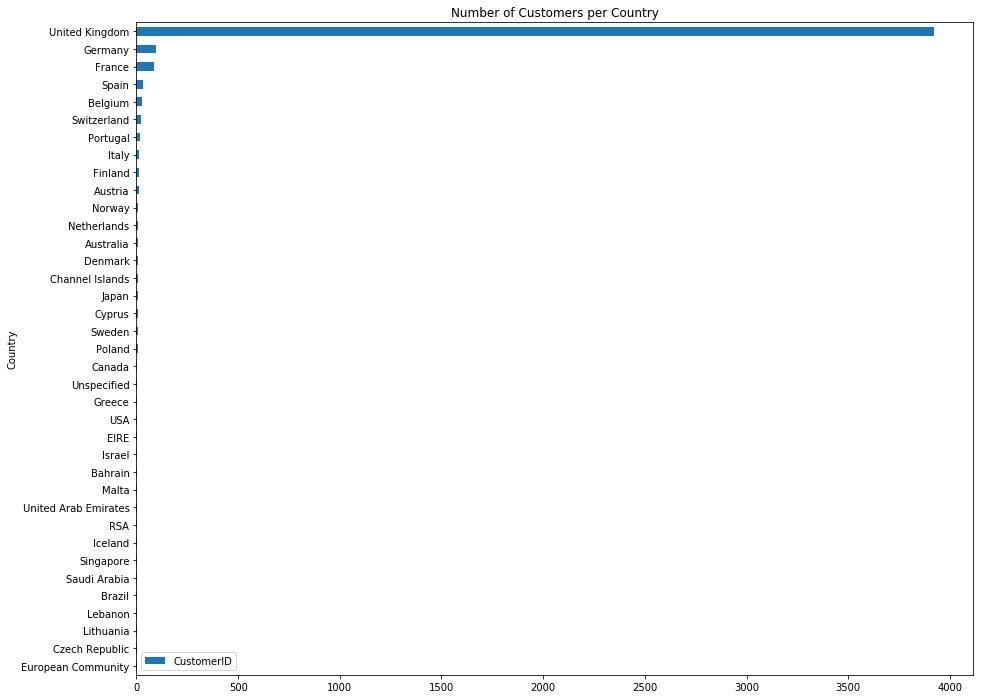

In [26]:
countryCust.sort_values(by = 'CustomerID').plot(kind='barh', figsize=(15,12))
plt.title('Number of Customers per Country')

Text(0.5,1,'Number of Invoices per Country')

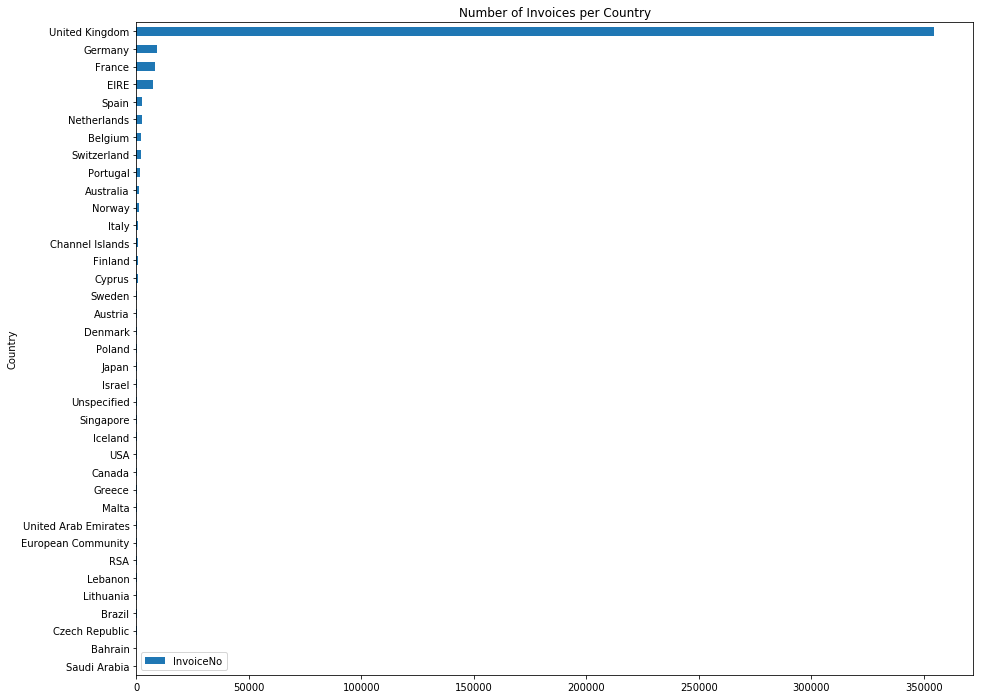

In [35]:
countryInv = df.loc[:,['Country', 'InvoiceNo']].groupby('Country').count()
countryInv.sort_values(by='InvoiceNo').plot(kind='barh', figsize=(15,12))
plt.title('Number of Invoices per Country')

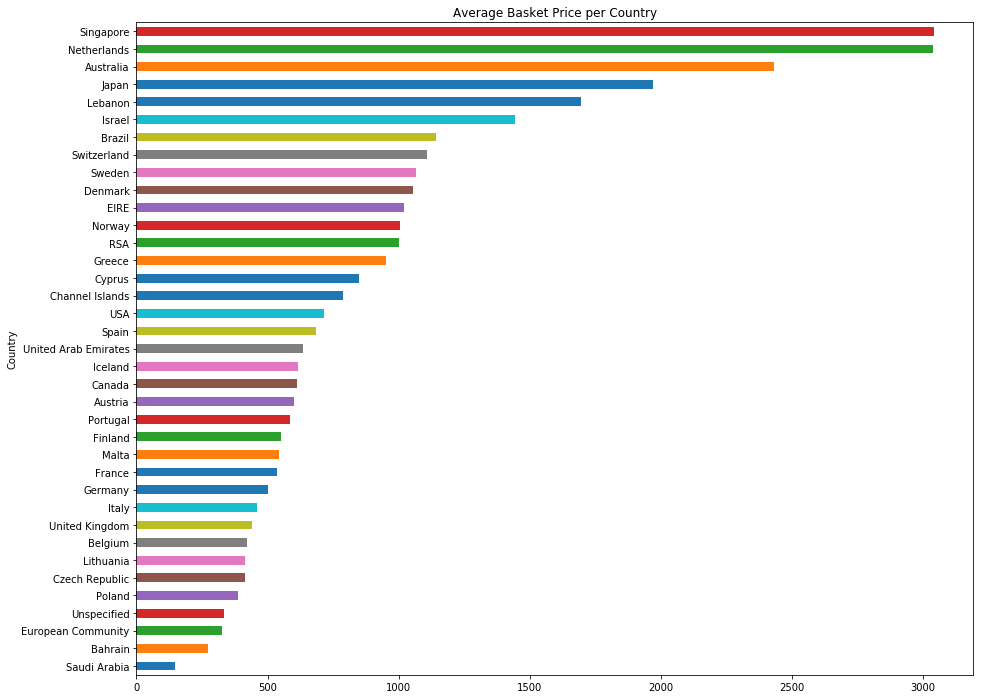

In [37]:
bestBuyer = df.groupby(['Country', 'InvoiceNo'])['TotalPrice'].sum().reset_index().groupby(['Country'])['TotalPrice'].mean().sort_values()
bestBuyer.plot(kind='barh', figsize=(15,12))
plt.title("Average Basket Price per Country")
plt.show()

In [49]:
countryRankSorted = bestBuyer.rank().to_dict()
df['CountryRank'] = df["Country"].apply(lambda x:countryRankSorted[x])
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,CountryRank
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,9.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,9.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,9.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,9.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,9.0


In [51]:
X = df["Description"].unique()

3877

In [53]:
stemmer = nltk.stem.porter.PorterStemmer()
stopword = nltk.corpus.stopwords.words('english')

In [58]:
def stem_and_filter(doc):
    tokens = [stemmer.stem(w) for w in analyzer(doc)]
    return [token for token in tokens if token.isalpha()]

analyzer = CountVectorizer().build_analyzer()
CV = CountVectorizer(lowercase=True, stop_words="english", analyzer=stem_and_filter)
TF_matrix = CV.fit_transform(X)
print("TF_matrix :", TF_matrix.shape, "of", TF_matrix.dtype)

analyzer = TfidfVectorizer().build_analyzer()
CV = TfidfVectorizer(lowercase=True, stop_words="english", analyzer=stem_and_filter, min_df=0.00, max_df=0.3)  # we remove words if it appears in more than 30 % of the corpus (not found stopwords like Box, Christmas and so on)
TF_IDF_matrix = CV.fit_transform(X)
print("TF_IDF_matrix :", TF_IDF_matrix.shape, "of", TF_IDF_matrix.dtype)

TF_matrix : (3877, 1697) of int64
TF_IDF_matrix : (3877, 1697) of float64


## RFM-сегментация

Делаем по данным UK

In [ ]:
df1 = df[df.Country == 'United Kingdom']

In [ ]:
df1.InvoiceDate.max()

In [ ]:
now = dt.datetime(2011,12,10)

In [ ]:
rfm = df1.groupby('CustomerID').agg({'InvoiceDate': lambda x: (now - x.max()).days, 
                                     'InvoiceNo': lambda x: len(x), 
                                     'TotalPrice': lambda x: x.sum()})

In [ ]:
rfm.columns = ['Recency', 'Frequency', 'MonetaryValue']

## Сегментация методами машинного обучения 

In [66]:
svd = TruncatedSVD(n_components = 100)
normalizer = Normalizer(copy=False)

TF_embedded = svd.fit_transform(TF_matrix)
TF_embedded = normalizer.fit_transform(TF_embedded)
print("TF_embedded :", TF_embedded.shape, "of", TF_embedded.dtype)

TF_IDF_embedded = svd.fit_transform(TF_IDF_matrix)
TF_IDF_embedded = normalizer.fit_transform(TF_IDF_embedded)
print("TF_IDF_embedded :", TF_IDF_embedded.shape, "of", TF_IDF_embedded.dtype)

TF_embedded : (3877, 100) of float64
TF_IDF_embedded : (3877, 100) of float64


In [72]:
score_tf = []
score_tfidf = []

for n_clusters in range(2, 10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=10)
    kmeans.fit(TF_embedded)
    clusters = kmeans.predict(TF_embedded)
    silhouette_avg = silhouette_score(TF_embedded, clusters)
#     print("N clusters =", n_clusters, "Silhouette Score :", silhouette_avg)

for n_clusters in range(2, 10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=10)
    kmeans.fit(TF_IDF_embedded)
    clusters = kmeans.predict(TF_IDF_embedded)
    silhouette_avg = silhouette_score(TF_IDF_embedded, clusters)
#     print("N clusters =", n_clusters, "Silhouette Score :", silhouette_avg)

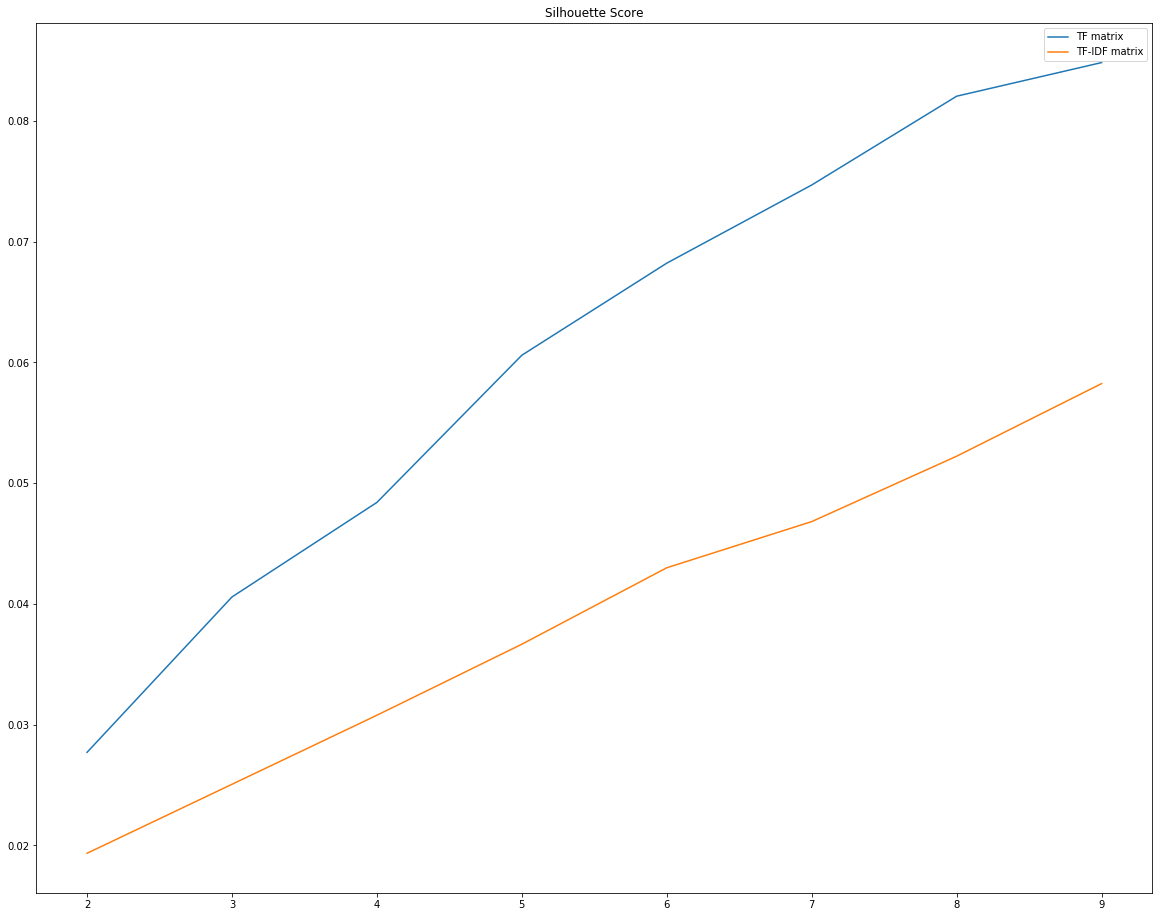

In [75]:
plt.figure(figsize=(20,16))
x = list(range(2, 10))
plt.plot(x, score_tf, label="TF matrix")
plt.plot(x, score_tfidf, label="TF-IDF matrix")
plt.title("Silhouette Score")
plt.legend()

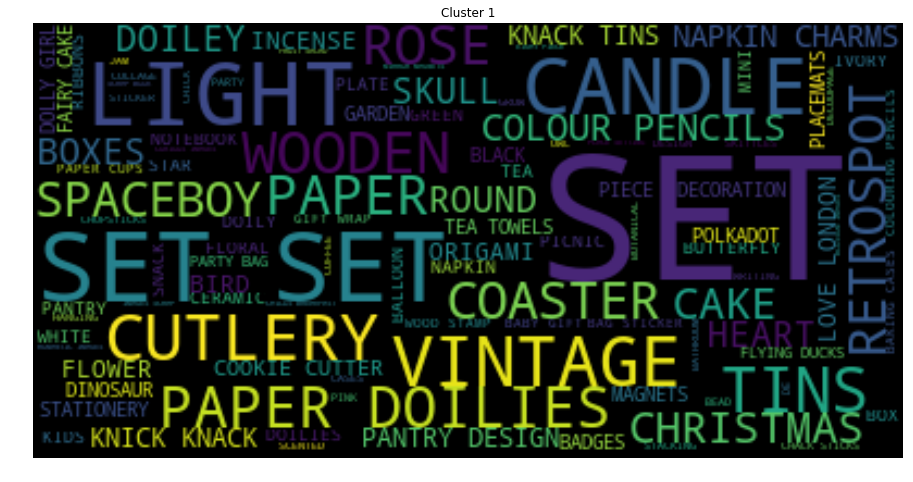

In [96]:
kmeans = KMeans(init='k-means++', n_clusters = 10, n_init=10)
kmeans.fit(TF_embedded)
clusters = kmeans.predict(TF_embedded)
silhouette_avg = silhouette_score(TF_embedded, clusters)

cluster = 1
plt.figure(figsize=(20,8))
wc.generate(" ".join(X[np.where(clusters==cluster)]))
plt.imshow(wc, interpolation='bilinear')
plt.title("Cluster {}".format(cluster))
plt.axis("off")
plt.show()